# Music Generation with an LSTM Network

**You will learn to:**
- Apply an LSTM to music generation.
- Generate your own jazz music with deep learning.

Please run the following cell to load all the packages required in this assignment.

In [3]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


import os
os.chdir('/content/drive/My Drive/SYM_TD_TPs/Music Generation/P2 LSTM Network')
!pwd
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SYM_TD_TPs/Sequence Models/week1/LSTM Network
 data		 inference_code.py	       music_utils.py   qa.py
 data_utils.py	 jazz_improv.py		       output	        tune1.midi
 grammar.py	 midi.py		       preprocess.py
 images		'Music generation RNN.ipynb'   __pycache__


In [4]:
from __future__ import print_function
import IPython
import sys
from music21 import *
import numpy as np
from grammar import *
from qa import *
from preprocess import * 
from music_utils import *
from data_utils import *
from keras.models import load_model, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
from IPython.display import Image

Using TensorFlow backend.


## 1 - Problem statement


You will train a network to generate novel jazz solos in a style representative of a body of performed work.


### 1.1 - Dataset

You will train your algorithm on a corpus of Jazz music. **You can listen directly the audio file "30s_seq.mp3" in the "data" folder.**

The musical data was rendered to terms of musical "values." You can informally think of each "value" as a note, which comprises a pitch and a duration. For the purpose of this exercice, all you need to know is that we will obtain a dataset of values, and will learn an RNN model to generate sequences of values. 

Our music generation system will use 78 unique values.

In [0]:
X, Y, n_values, indices_values = load_music_utils()
print('shape of X:', X.shape)
print('number of training examples:', X.shape[0])
print('Tx (length of sequence):', X.shape[1])
print('total # of unique values:', n_values)
print('Shape of Y:', Y.shape)

shape of X: (60, 30, 78)
number of training examples: 60
Tx (length of sequence): 30
total # of unique values: 78
Shape of Y: (30, 60, 78)


You have just loaded the following:

- `X`: This is an (m, $T_x$, 78) dimensional array. We have m training examples, each of which is a snippet of $T_x =30$ musical values. At each time step, the input is one of 78 different possible values, represented as a one-hot vector. Thus for example, X[i,t,:] is a one-hot vector representating the value of the i-th example at time t. 

- `Y`: This is essentially the same as `X`, but shifted one step to the left (to the past). We're interested in the network using the previous values to predict the next value, so our sequence model will try to predict $y^{\langle t \rangle}$ given $x^{\langle 1\rangle}, \ldots, x^{\langle t \rangle}$. However, the data in `Y` is reordered to be dimension $(T_y, m, 78)$, where $T_y = T_x$. This format makes it more convenient to feed to the LSTM later. 

- `n_values`: The number of unique values in this dataset. This should be 78. 

- `indices_values`: python dictionary mapping from 0-77 to musical values.

### 1.2 - Overview of our model

Here is the architecture of the model we will use.

<!--
<img src="images/djmodel.png" style="width:600;height:400px;">
<br>
<caption><center> **Figure 1**: LSTM model. $X = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$ is a window of size $T_x$ scanned over the musical corpus. Each $x^{\langle t \rangle}$ is an index corresponding to a value (ex: "A,0.250,< m2,P-4 >") while $\hat{y}$ is the prediction for the next value  </center></caption>
!--> 

We will be training the model on random snippets of 30 values taken from a much longer piece of music. We are setting each of the snippts to have the same length $T_x = 30$ to make vectorization easier. 


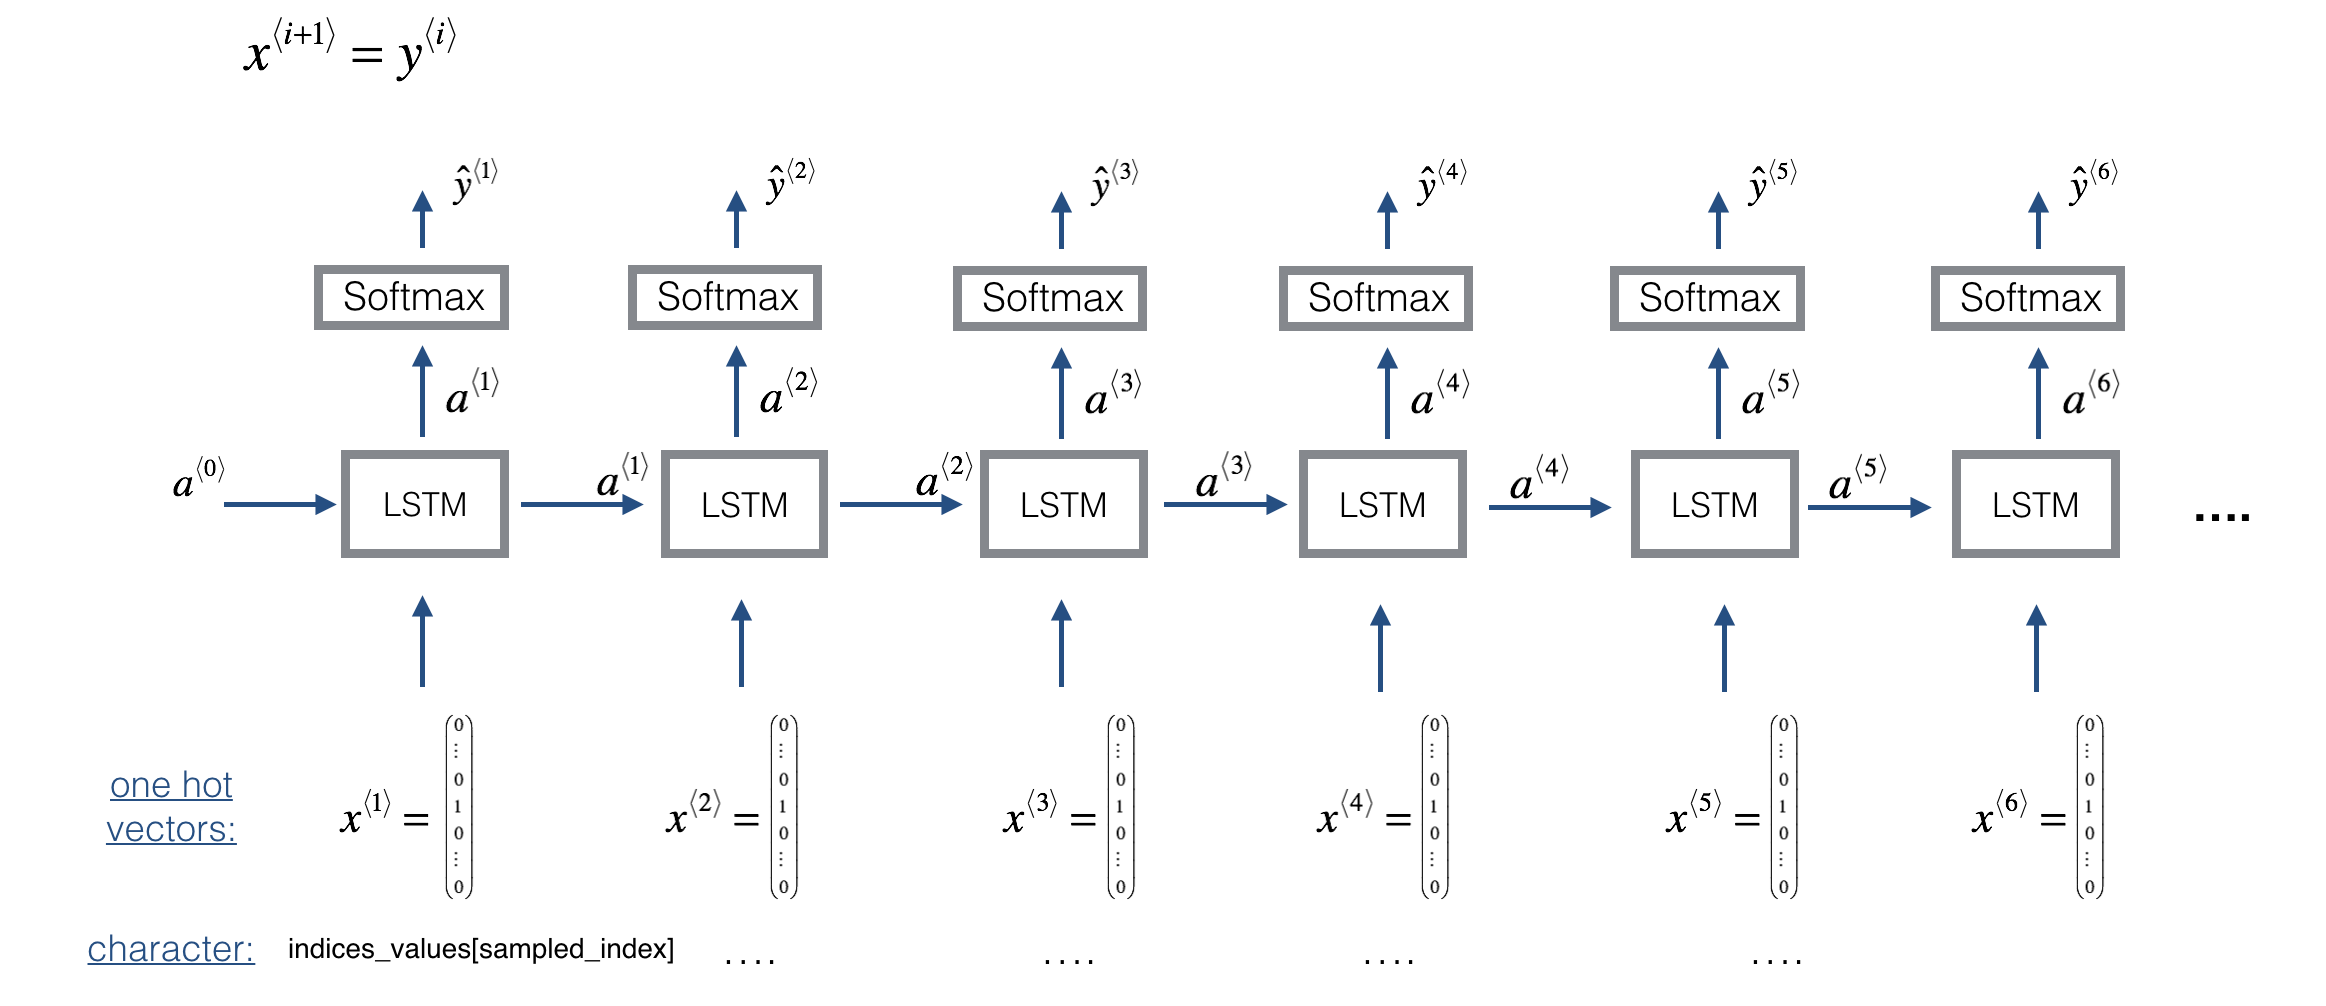

In [6]:
Image("images/music_generation.png",width=900,height=500)

## 2 - Building the model

You will build and train a model that will learn musical patterns. You will need to build a model that takes in X of shape $(m, T_x, 78)$ and Y of shape $(T_y, m, 78)$. We will use an LSTM with 64 dimensional hidden states. Lets set `n_a = 64`. 


In [0]:
n_a = 64 


Here's how you can create a Keras model with multiple inputs and outputs. For sequence generation, at test time we don't know all the values of $x^{\langle t\rangle}$ in advance; instead we generate them one at a time using $x^{\langle t\rangle} = y^{\langle t-1 \rangle}$ and you'll need to implement your own for-loop to iterate over the different time steps. 

The function `djmodel()` will call the LSTM layer $T_x$ times using a for-loop. Important: $T_x$ copies have the same weights (it should not re-initiaiize the weights every time).
The key steps for implementing layers with shareable weights in Keras are: 
1. Define the layer objects (use global variables).
2. Call these objects when propagating the input.

Please check the Keras documentation to make sure you understand what these layers are: [Reshape()](https://keras.io/layers/core/#reshape), [LSTM()](https://keras.io/layers/recurrent/#lstm), [Dense()](https://keras.io/layers/core/#dense).


In [0]:
reshapor = Reshape((1, 78))                        # Used in Step 2.B of djmodel(), below
LSTM_cell = LSTM(n_a, return_state = True)         # Used in Step 2.C
densor = Dense(n_values, activation='softmax')     # Used in Step 2.D

To propagate a Keras tensor object X through one of these layers, use `layer_object(X)` (or `layer_object([X,Y])` if it requires multiple inputs.). For example, `reshapor(X)` will propagate X through the `Reshape((1,78))` layer defined above.

 
**Exercise**: Implement `djmodel()`. You will need to carry out 2 steps:

1. Create an empty list "outputs" to save the outputs of the LSTM Cell at every time step.
2. Loop for $t \in 1, \ldots, T_x$:

    A. Select the "t"th time-step vector from X (the shape should be (78,)). To do so, create a custom [Lambda](https://keras.io/layers/core/#lambda) layer in Keras:
```    
           x = Lambda(lambda x: X[:,t,:])(X)
``` 
Look over the Keras documentation to figure out what this does. It is creating a "temporary" or "unnamed" function (that's what Lambda functions are) that extracts out the appropriate one-hot vector, and making this function a Keras `Layer` object to apply to `X`. 

    B. Reshape x to be (1,78). You may find the `reshapor()` layer (defined below) helpful.

    C. Run x through one step of LSTM_cell. Remember to initialize the LSTM_cell with the previous step's hidden state $a$ and cell state $c$. Use the following formatting:
```python
a, _, c = LSTM_cell(input_x, initial_state=[previous hidden state, previous cell state])
```

    D. Propagate the LSTM's output activation value through a dense+softmax layer using `densor`. 
    
    E. Append the predicted value to the list of "outputs"
 


In [0]:
# GRADED FUNCTION: djmodel

def djmodel(Tx, n_a, n_values):
    """
    Implement the model
    
    Arguments:
    Tx -- length of the sequence in a corpus
    n_a -- the number of activations used in our model
    n_values -- number of unique values in the music data 
    
    Returns:
    model -- a keras model with the 
    """
    
    # Define the input of your model with a shape 
    X = Input(shape=(Tx, n_values))
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    
    ### START CODE HERE ### 
    # Step 1: Create empty list to append the outputs while you iterate (≈1 line)
    outputs = ...
    
    # Step 2: Loop
    for t in range(Tx):
        
        # Step 2.A: select the "t"th time step vector from X. 
        x = Lambda(lambda x: X[:,t,:])(X)
        # Step 2.B: Use reshapor to reshape x to be (1, n_values) (≈1 line)
        x = ...
        # Step 2.C: Perform one step of the LSTM_cell
        a, _, c = ...
        # Step 2.D: Apply densor to the hidden state output of LSTM_Cell
        out = ...
        # Step 2.E: add the output to "outputs"
        outputs.append(out)
        
    # Step 3: Create model instance
    model = Model(inputs=[X, a0, c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

Run the following cell to define your model. We will use `Tx=30`, `n_a=64` (the dimension of the LSTM activations), and `n_values=78`.

You then need to compile your model to be trained. We will Adam and a categorical cross-entropy loss.

In [0]:
model = djmodel(Tx = 30 , n_a = 64, n_values = 78)

opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Finally, lets initialize `a0` and `c0` for the LSTM's initial state to be zero. 

In [0]:
m = 60
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

Lets now fit the model! We will turn `Y` to a list before doing so, since the cost function expects `Y` to be provided in this format (one list item per time-step). So `list(Y)` is a list with 30 items, where each of the list items is of shape (60,78). Lets train for 100 epochs. This will take a few minutes. 



In [0]:
model.fit([X, a0, c0], list(Y), epochs=100)

Epoch 1/100
60/60 [==============================] - 18s 303ms/step - loss: 126.0066 - dense_1_loss: 0.0000e+00 - dense_1_acc: 0.0167 - dense_1_acc_1: 0.0500 - dense_1_acc_2: 0.0000e+00 - dense_1_acc_3: 0.0000e+00 - dense_1_acc_4: 0.0500 - dense_1_acc_5: 0.0333 - dense_1_acc_6: 0.0000e+00 - dense_1_acc_7: 0.0500 - dense_1_acc_8: 0.0167 - dense_1_acc_9: 0.0500 - dense_1_acc_10: 0.0500 - dense_1_acc_11: 0.0500 - dense_1_acc_12: 0.0500 - dense_1_acc_13: 0.1000 - dense_1_acc_14: 0.0833 - dense_1_acc_15: 0.0333 - dense_1_acc_16: 0.0667 - dense_1_acc_17: 0.0500 - dense_1_acc_18: 0.0667 - dense_1_acc_19: 0.0000e+00 - dense_1_acc_20: 0.0167 - dense_1_acc_21: 0.0333 - dense_1_acc_22: 0.0667 - dense_1_acc_23: 0.0500 - dense_1_acc_24: 0.0833 - dense_1_acc_25: 0.0667 - dense_1_acc_26: 0.0333 - dense_1_acc_27: 0.0833 - dense_1_acc_28: 0.0667 - dense_1_acc_29: 0.0167                                                              
Epoch 2/100
60/60 [==============================] - 0s 6ms/step - loss:

You have trained a model, lets go on the the final section to implement an inference algorithm, and generate some music! 

## 3 - Generating music

You now have a trained model which has learned the patterns of the jazz soloist. Lets now use this model to synthesize new music. 

#### 3.1 - Predicting & Sampling

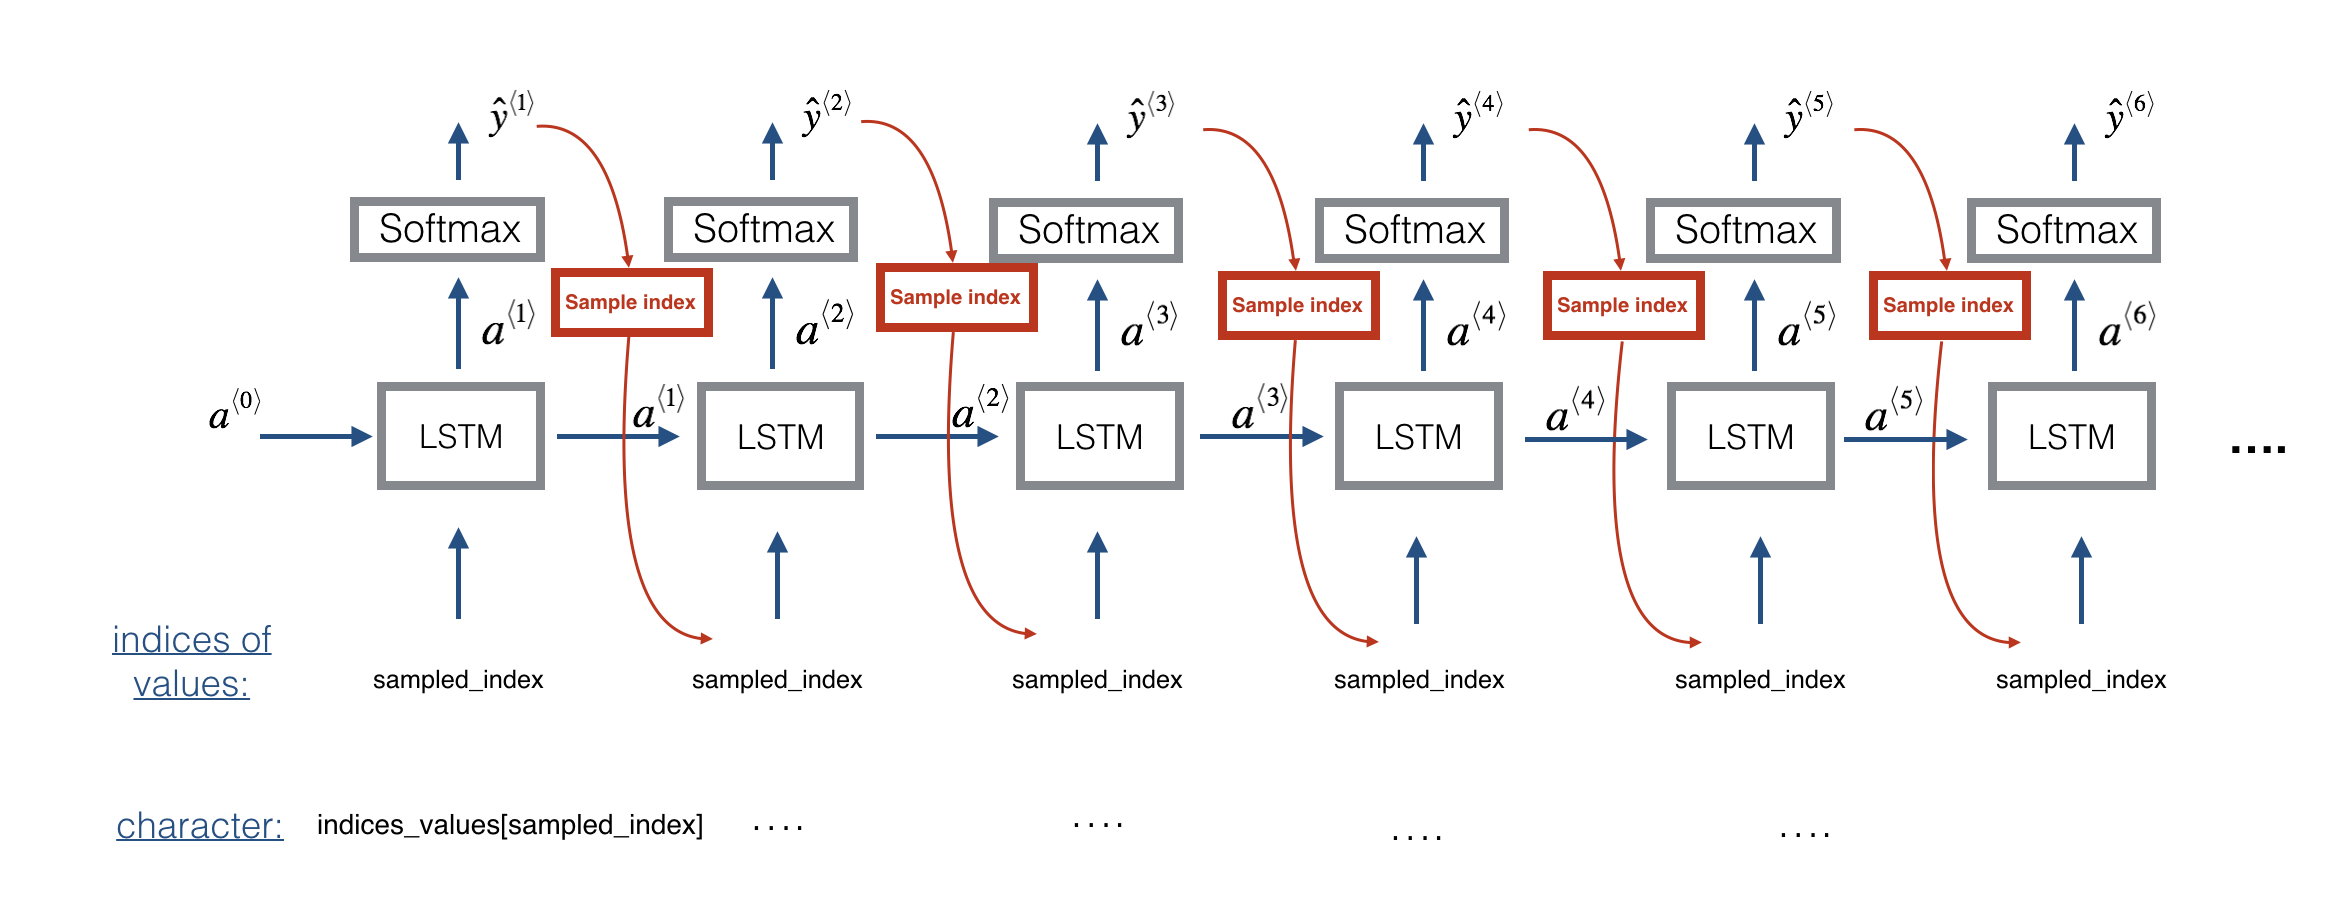

In [7]:
Image("images/music_gen.png",width=900,height=500)

At each step of sampling, you will take as input the activation `a` and cell state `c` from the previous state of the LSTM, forward propagate by one step, and *get* a new output activation as well as cell state. The new activation `a` can then be used to generate the output, using `densor` as before. 

Initialize `x0` as well as the LSTM activation and and cell value `a0` and `c0` to be zeros. 


<!-- 
You are about to build a function that will do this inference for you. Your function takes in your previous model and the number of time steps `Ty` that you want to sample. It will return a keras model that would be able to generate sequences for you. Furthermore, the function takes in a dense layer of `78` units and the number of activations. 
!--> 


**Exercise:** Implement the function below to sample a sequence of musical values. Here are some of the key steps: 

Step 2.A: Use `LSTM_Cell`, which inputs the previous step's `c` and `a` to generate the current step's `c` and `a`. 

Step 2.B: Use `densor` (defined previously) to compute a softmax on `a` to get the output for the current step. 

Step 2.C: Save the output you have just generated by appending it to `outputs`.

Step 2.D: Sample x to the be "out"'s one-hot version (the prediction) so that you can pass it to the next LSTM's step.  We have already provided this line of code, which uses a [Lambda](https://keras.io/layers/core/#lambda) function. 
```python
x = Lambda(one_hot)(out) 
```
[Minor technical note: Rather than sampling a value at random according to the probabilities in `out`, this line of code actually chooses the single most likely note at each step using an argmax.]


In [0]:
# GRADED FUNCTION: music_inference_model

def music_inference_model(LSTM_cell, densor, n_values = 78, n_a = 64, Ty = 100):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    n_values -- integer, umber of unique values
    n_a -- number of units in the LSTM_cell
    Ty -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance
    """
    
    # Define the input of your model with a shape 
    x0 = Input(shape=(1, n_values))
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    ### START CODE HERE ###
    # Step 1: Create an empty list of "outputs" to later store your predicted values (≈1 line)
    outputs = []
    
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty):
        
        # Step 2.A: Perform one step of LSTM_cell (≈1 line)
        a, _, c = ...
        
        # Step 2.B: Apply Dense layer to the hidden state output of the LSTM_cell (≈1 line)
        out = ...

        # Step 2.C: Append the prediction "out" to "outputs". out.shape = (None, 78) (≈1 line)
        ...
        
        # Step 2.D: Select the next value according to "out", and set "x" to be the one-hot representation of the
        #           selected value, which will be passed as the input to LSTM_cell on the next step. We have provided 
        #           the line of code you need to do this. 
        x = Lambda(one_hot)(out)
        
    # Step 3: Create model instance with the correct "inputs" and "outputs" (≈1 line)
    inference_model = Model(inputs=[x0, a0, c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return inference_model

Run the cell below to define your inference model. This model is hard coded to generate 50 values.

In [0]:
inference_model = music_inference_model(LSTM_cell, densor, n_values = 78, n_a = 64, Ty = 50)

Finally, this creates the zero-valued vectors you will use to initialize `x` and the LSTM state variables `a` and `c`. 

In [0]:
x_initializer = np.zeros((1, 1, 78))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

**Exercise**: Implement `predict_and_sample()`. This function takes many arguments including the inputs [x_initializer, a_initializer, c_initializer]. In order to predict the output corresponding to this input, you will need to carry-out 3 steps:
1. Use your inference model to predict an output given your set of inputs. The output `pred` should be a list of length $T_y$ where each element is a numpy-array of shape (1, n_values).
2. Convert `pred` into a numpy array of $T_y$ indices. Each index corresponds is computed by taking the `argmax` of an element of the `pred` list. [Hint](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html).
3. Convert the indices into their one-hot vector representations. [Hint](https://keras.io/utils/#to_categorical).

In [0]:
# GRADED FUNCTION: predict_and_sample

def predict_and_sample(inference_model, x_initializer = x_initializer, a_initializer = a_initializer, 
                       c_initializer = c_initializer):
    """
    Predicts the next value of values using the inference model.
    
    Arguments:
    inference_model -- Keras model instance for inference time
    x_initializer -- numpy array of shape (1, 1, 78), one-hot vector initializing the values generation
    a_initializer -- numpy array of shape (1, n_a), initializing the hidden state of the LSTM_cell
    c_initializer -- numpy array of shape (1, n_a), initializing the cell state of the LSTM_cel
    
    Returns:
    results -- numpy-array of shape (Ty, 78), matrix of one-hot vectors representing the values generated
    indices -- numpy-array of shape (Ty, 1), matrix of indices representing the values generated
    """
    
    ### START CODE HERE ###
    # Step 1: Use your inference model to predict an output sequence given x_initializer, a_initializer and c_initializer.
    pred = inference_model.predict([x_initializer, a_initializer, c_initializer])
    print('Number of outputs: %s' % str(len(pred)))
    print('Shape prob per time: %s' % str(pred[0].shape))
    # Step 2: Convert "pred" into an np.array() of indices with the maximum probabilities
    indices = np.argmax(pred, axis=2)
    print('Print shape, index per time sample: %s' % str(indices.shape))
    # Step 3: Convert indices to one-hot vectors, the shape of the results should be (1, )
    print('Print value for 0: %s' % str(indices[0]))
    results = to_categorical(indices)
    print('Print value for 0, one-hot: %s' % str(results[0]))
    ### END CODE HERE ###
    
    return results, indices

In [0]:
results, indices = predict_and_sample(inference_model, x_initializer, a_initializer, c_initializer)
print("np.argmax(results[12]) =", np.argmax(results[12]))
print("np.argmax(results[17]) =", np.argmax(results[17]))
print("list(indices[12:18]) =", list(indices[12:18]))

Number of outputs: 50
Shape prob per time: (1, 78)
Print shape, index per time sample: (50, 1)
Print value for 0: [71]
Print value for 0, one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
np.argmax(results[12]) = 29
np.argmax(results[17]) = 37
list(indices[12:18]) = [array([29]), array([10]), array([68]), array([49]), array([16]), array([37])]


**Expected Output**: Your results may differ because Keras' results are not completely predictable. However, if you have trained your LSTM_cell with model.fit() for exactly 100 epochs as described above, you should very likely observe a sequence of indices that are not all identical. Moreover, you should observe that: np.argmax(results[12]) is the first element of list(indices[12:18]) and np.argmax(results[17]) is the last element of list(indices[12:18]). 

<table>
    <tr>
        <td>
            **np.argmax(results[12])** =
        </td>
        <td>
        1
        </td>
    </tr>
    <tr>
        <td>
            **np.argmax(results[12])** =
        </td>
        <td>
        42
        </td>
    </tr>
    <tr>
        <td>
            **list(indices[12:18])** =
        </td>
        <td>
            [array([1]), array([42]), array([54]), array([17]), array([1]), array([42])]
        </td>
    </tr>
</table>

#### 3.3 - Generate music 

Finally, you are ready to generate music. Your RNN generates a sequence of values. The following code generates music by first calling your `predict_and_sample()` function. These values are then post-processed into musical chords (meaning that multiple values or notes can be played at the same time). 

Most computational music algorithms use some post-processing because it is difficult to generate music that sounds good without such post-processing. The post-processing does things such as clean up the generated audio by making sure the same sound is not repeated too many times, that two successive notes are not too far from each other in pitch, and so on. One could argue that a lot of these post-processing steps are hacks; also, a lot the music generation literature has also focused on hand-crafting post-processors, and a lot of the output quality depends on the quality of the post-processing and not just the quality of the RNN. But this post-processing does make a huge difference, so lets use it in our implementation as well. 

Lets make some music! 

Run the following cell to generate music and record it into your `out_stream`. This can take a couple of minutes.

In [0]:
out_stream = generate_music(inference_model)

Predicting new values for different set of chords.
Generated 51 sounds using the predicted values for the set of chords ("1") and after pruning
Generated 51 sounds using the predicted values for the set of chords ("2") and after pruning
Generated 51 sounds using the predicted values for the set of chords ("3") and after pruning
Generated 50 sounds using the predicted values for the set of chords ("4") and after pruning
Generated 51 sounds using the predicted values for the set of chords ("5") and after pruning
Your generated music is saved in output/my_music.midi


Download "my_music.midi" in the "output" to listen to your music.

As reference, listen to "/data/30s_trained_model.mp3"